In [31]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from tensorflow import keras
from torch.utils.data import Dataset
import torch.nn.functional as F

In [32]:
class MNISTDataset(Dataset):
    def __init__(self, image, label):
        self.image = torch.tensor(image, dtype = torch.float32)
        self.label = label

    def __len__(self): return len(self.label)

    def __getitem__(self, idx):
        image_ = self.image[idx]
        image_ = image_[None, :]
        label_ = self.label[idx]
        return image_, label_
        

In [33]:
(x_tr, y_tr), (x_ts, y_ts) = keras.datasets.mnist.load_data()
x_tr, y_tr = x_tr[0:6400], y_tr[0:6400]
x_ts, y_ts = x_ts[0:640], y_ts[0:640]
trainset = MNISTDataset(x_tr, y_tr)
valset = MNISTDataset(x_ts, y_ts)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [34]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [35]:
n_epochs = 6
learning_rate = 0.006
momentum = 0.5
log_interval = 5

networks, opts = [], []


# for i in range(len(parameters)):
#     network = Net()
#     networks.append(network)
#     optimizer = optim.SGD(network.parameters(), lr=learning_rate,
#                       momentum=momentum)
#     opts.append(optimizer)
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)


train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(trainloader.dataset) for i in range(n_epochs + 1)]


In [36]:
derivative = [[]]*10

def train(epoch, para = 10):
  
  i = 0
  network.train()
  for batch_idx, (data, target) in enumerate(trainloader):
    data.requires_grad_(True)
    
    optimizer.zero_grad()
    output = network(data)
    # print(output.shape)
    
    loss = F.nll_loss(output, target)
    loss.backward(retain_graph=True)
    
    first_derivative = data.grad
    # print(first_derivative.shape) # 64*1*28*28
    first_derivative = first_derivative.view(64, -1)
    # print(first_derivative[1].shape) # 64, 784
    
    # print(i)  
    for j in range(len(first_derivative)):
        # print(len(first_derivative))
        derivative[y_tr[i]].append(first_derivative[j])
        i += 1
    # print(i)  
    
      
    loss_all = []
    for j in range(10):
        temp = torch.stack(derivative[j])
        # print(temp.shape)
        mean = torch.mean(temp, dim = 0)
        # print(mean.shape)
        # print(derivative[0][0].shape)
        l = 0
        for k in range(len(derivative[j])):
            loss2 = torch.nn.MSELoss()
            l += loss2(mean, derivative[j][k])
        loss_all.append(l)
    
    # print(loss_all)
    derivative_loss = para*sum(loss_all)
    loss += derivative_loss
    loss.backward(retain_graph=True)

    optimizer.step()
    if batch_idx % log_interval == 0:
      print("derivative loss:", derivative_loss)
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(trainloader.dataset),
        100. * batch_idx / len(trainloader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
         (batch_idx*64) + ((epoch-1)*len(trainloader.dataset)))
    
    # derivative = new_derivative
    # new_derivative = []*10

In [37]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in valloader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(valloader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(valloader.dataset),
    100. * correct / len(valloader.dataset)))

In [38]:
with open('features_UMAP.npy', 'rb') as f:
    train_x = np.load(f)
    train_y_label = np.load(f)
    test_x = np.load(f)
    test_y = np.load(f)
    
train_x, train_y_label, test_x, test_y = \
    torch.from_numpy(train_x), torch.from_numpy(train_y_label), \
        torch.from_numpy(test_x), torch.from_numpy(test_y)


In [39]:
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

In [40]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        # self.covar_module = gpytorch.kernels.ScaleKernel(RBFKernel())
        self.covar_module = gpytorch.kernels.MaternKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [41]:
def scores(loader):
    network.eval()
    # outputs = [] 
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            output = network(data)
            # outputs.append(output)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(loader.dataset),
        100. * correct / len(loader.dataset)))
    return output

In [42]:
n = 2000
all_index = np.arange(0, n)
models, likelihoods, mlls, opts = [], [], [], []
lr = 0.1

def model_initialize_GP():


    for j in range(10):
        mo, l, ml, o = [], [], [], []
        for k in range(10):
            val_index = np.arange(np.floor(n/10)*k, np.floor(n/10)*(k+1))
            train_index = [i for i in all_index if i not in val_index]
            x = train_x[train_index, :]
            y = log_y[train_index, j]
            
            likelihood = gpytorch.likelihoods.GaussianLikelihood()
            model = ExactGPModel(x, y, likelihood)
            likelihood.train()
            model.train()
            mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
            
            l.append(likelihood)
            mo.append(model)
            ml.append(mll)
            
            optimizer = torch.optim.Adam(model.parameters(), lr = lr)  # Includes GaussianLikelihood parameters
            o.append(optimizer)
            
        models.append(mo)
        likelihoods.append(l)
        mlls.append(ml)
        opts.append(o)
        
    # models[0][1] represents label 0 and the first fold
        

In [43]:
pred_train_y = []
def train_GP():
    training_iter = 10
    # train_y = torch.load('train_score.pt') : x axis

    for j in range(10):  # j represents the 10 labels
        p = []
        for k in range(10): # k represents the k fold cross validation
            print("Model", j, ", Cross Validation Group", k)
            # initialize the model
            val_index = np.arange(np.floor(n/10)*k, np.floor(n/10)*(k+1))
            train_index = [i for i in all_index if i not in val_index]
            tr_x = train_x[train_index, :]
            val_x = train_x[val_index, :]
            tr_y = log_y[train_index, j]
            # val_y = train_y[val_index, k]
            likelihood = likelihoods[j][k]
            model = models[j][k]
            mll = mlls[j][k]
            optimizer = opts[j][k]
            
            # training
            for i in range(training_iter):                
                # Zero gradients from previous iteration
                optimizer.zero_grad()
                # Output from model
                output = model(tr_x)
                # print(output.shape, tr_y.shape)
                
                # Calc loss and backprop gradients
                loss = -mll(output, tr_y)
                loss.backward()
                
                if i % 4 == 0:
                    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                        i + 1, training_iter, loss.item(),
                        #model.covar_module.base_kernel.lengthscale.item(),
                        0.1,
                        model.likelihood.noise.item()
                    ))
                optimizer.step()
            
                # evaluation of the current model
            model.eval()
            likelihood.eval()
            with gpytorch.settings.fast_pred_var(), torch.no_grad():
                test_dist = model(val_x)
                pred_means = test_dist.loc
                p.append(pred_means)
        p = torch.stack(p)
        pred_train_y.append(p)        
    

/tmp/ipykernel_250/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 10.0432, Accuracy: 72/640 (11%)

derivative loss: tensor(3.0821e-07)
Train Epoch: 1 [0/6400 (0%)]	Loss: 14.210112
derivative loss: tensor(1.9757e-06)
Train Epoch: 1 [320/6400 (5%)]	Loss: 2.315652
derivative loss: tensor(2.4788e-06)
Train Epoch: 1 [640/6400 (10%)]	Loss: 2.294719
derivative loss: tensor(2.9085e-06)
Train Epoch: 1 [960/6400 (15%)]	Loss: 2.277779
derivative loss: tensor(3.4052e-06)
Train Epoch: 1 [1280/6400 (20%)]	Loss: 2.291453
derivative loss: tensor(4.0099e-06)
Train Epoch: 1 [1600/6400 (25%)]	Loss: 2.172132
derivative loss: tensor(4.6688e-06)
Train Epoch: 1 [1920/6400 (30%)]	Loss: 2.128933
derivative loss: tensor(5.3849e-06)
Train Epoch: 1 [2240/6400 (35%)]	Loss: 2.036374
derivative loss: tensor(6.2696e-06)
Train Epoch: 1 [2560/6400 (40%)]	Loss: 1.940608
derivative loss: tensor(7.0402e-06)
Train Epoch: 1 [2880/6400 (45%)]	Loss: 1.746141
derivative loss: tensor(7.6892e-06)
Train Epoch: 1 [3200/6400 (50%)]	Loss: 1.679093
derivative loss: tensor(8.54

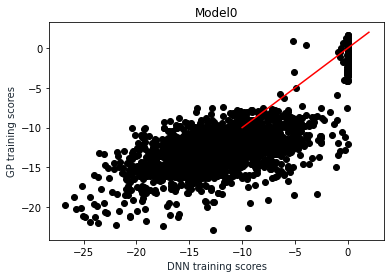

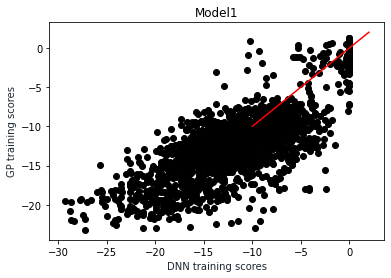

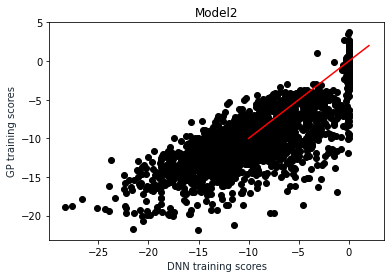

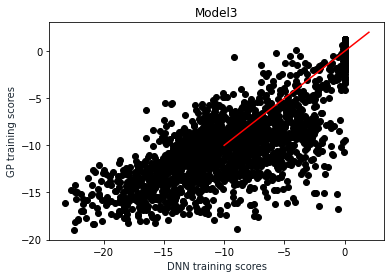

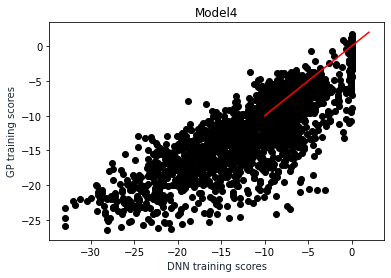

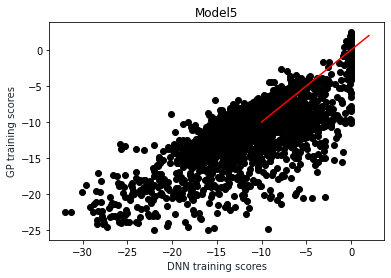

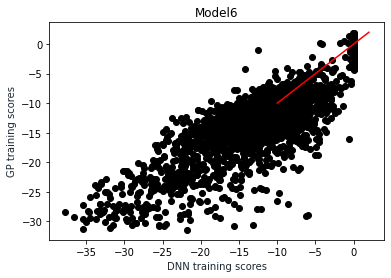

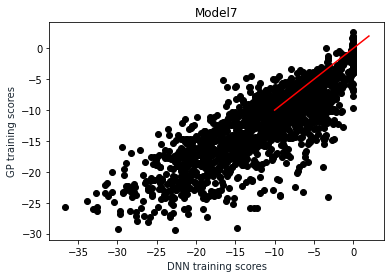

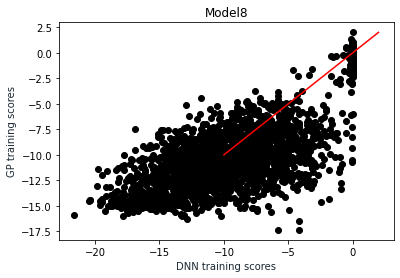

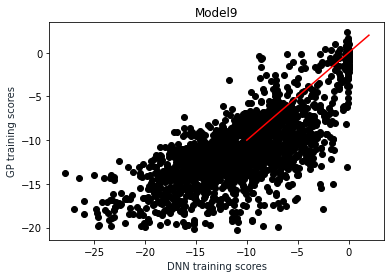

/tmp/ipykernel_250/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


derivative loss: tensor(0.0006)
Train Epoch: 1 [0/6400 (0%)]	Loss: 18.098404
derivative loss: tensor(0.0006)
Train Epoch: 1 [320/6400 (5%)]	Loss: 2.347337
derivative loss: tensor(0.0006)
Train Epoch: 1 [640/6400 (10%)]	Loss: 2.287185
derivative loss: tensor(0.0007)
Train Epoch: 1 [960/6400 (15%)]	Loss: 2.224232
derivative loss: tensor(0.0007)
Train Epoch: 1 [1280/6400 (20%)]	Loss: 2.224531
derivative loss: tensor(0.0007)
Train Epoch: 1 [1600/6400 (25%)]	Loss: 2.152346
derivative loss: tensor(0.0007)
Train Epoch: 1 [1920/6400 (30%)]	Loss: 2.008757
derivative loss: tensor(0.0007)
Train Epoch: 1 [2240/6400 (35%)]	Loss: 1.988351
derivative loss: tensor(0.0007)
Train Epoch: 1 [2560/6400 (40%)]	Loss: 2.014636
derivative loss: tensor(0.0007)
Train Epoch: 1 [2880/6400 (45%)]	Loss: 1.762395
derivative loss: tensor(0.0007)
Train Epoch: 1 [3200/6400 (50%)]	Loss: 1.600891
derivative loss: tensor(0.0007)
Train Epoch: 1 [3520/6400 (55%)]	Loss: 1.785273
derivative loss: tensor(0.0007)
Train Epoch: 1 

/home/cyy/.local/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9996, Accuracy: 469/640 (73%)

derivative loss: tensor(0.0007)
Train Epoch: 2 [0/6400 (0%)]	Loss: 1.145442
derivative loss: tensor(0.0007)
Train Epoch: 2 [320/6400 (5%)]	Loss: 1.100428
derivative loss: tensor(0.0007)
Train Epoch: 2 [640/6400 (10%)]	Loss: 1.360394
derivative loss: tensor(0.0007)
Train Epoch: 2 [960/6400 (15%)]	Loss: 1.118891
derivative loss: tensor(0.0007)
Train Epoch: 2 [1280/6400 (20%)]	Loss: 1.361125
derivative loss: tensor(0.0007)
Train Epoch: 2 [1600/6400 (25%)]	Loss: 1.200568
derivative loss: tensor(0.0007)
Train Epoch: 2 [1920/6400 (30%)]	Loss: 1.213817
derivative loss: tensor(0.0007)
Train Epoch: 2 [2240/6400 (35%)]	Loss: 1.221576
derivative loss: tensor(0.0007)
Train Epoch: 2 [2560/6400 (40%)]	Loss: 0.967819
derivative loss: tensor(0.0007)
Train Epoch: 2 [2880/6400 (45%)]	Loss: 1.088956
derivative loss: tensor(0.0007)
Train Epoch: 2 [3200/6400 (50%)]	Loss: 1.186894
derivative loss: tensor(0.0007)
Train Epoch: 2 [3520/6400 (55%)]	Loss: 1.

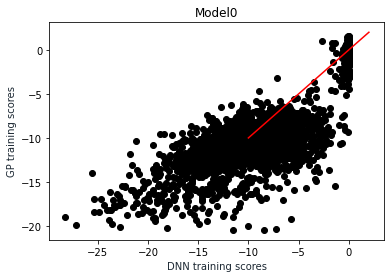

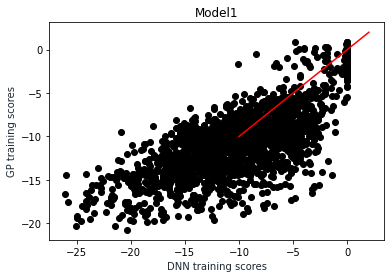

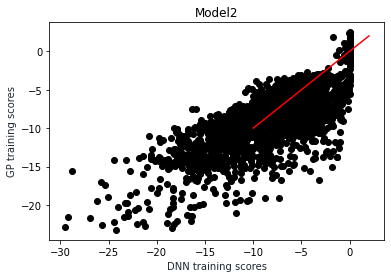

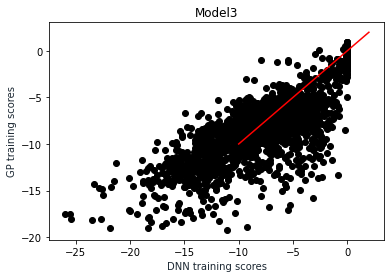

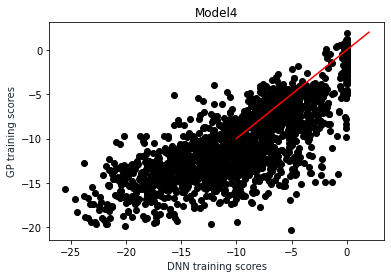

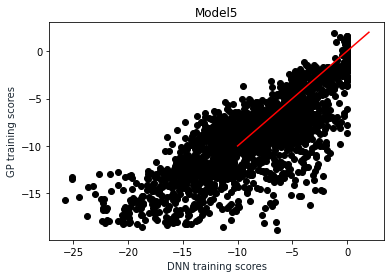

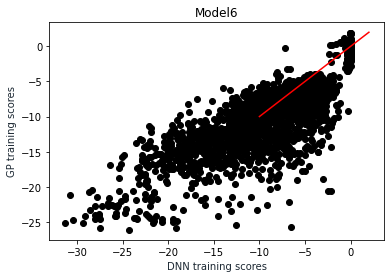

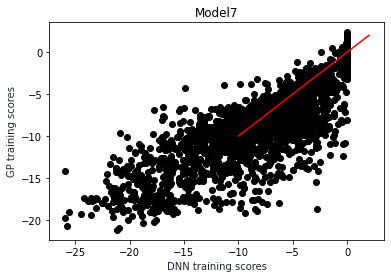

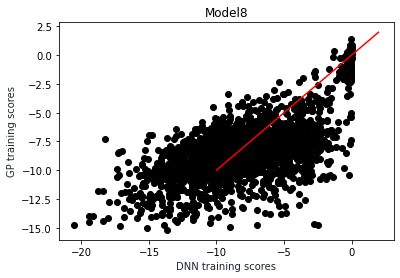

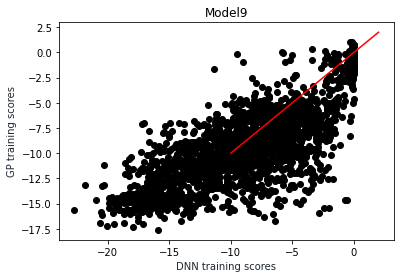

/tmp/ipykernel_250/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


derivative loss: tensor(0.0059)
Train Epoch: 1 [0/6400 (0%)]	Loss: 23.774191
derivative loss: tensor(0.0060)
Train Epoch: 1 [320/6400 (5%)]	Loss: 2.352273
derivative loss: tensor(0.0060)
Train Epoch: 1 [640/6400 (10%)]	Loss: 2.252761
derivative loss: tensor(0.0060)
Train Epoch: 1 [960/6400 (15%)]	Loss: 2.287000
derivative loss: tensor(0.0060)
Train Epoch: 1 [1280/6400 (20%)]	Loss: 2.335163
derivative loss: tensor(0.0061)
Train Epoch: 1 [1600/6400 (25%)]	Loss: 2.241892
derivative loss: tensor(0.0061)
Train Epoch: 1 [1920/6400 (30%)]	Loss: 2.276541
derivative loss: tensor(0.0061)
Train Epoch: 1 [2240/6400 (35%)]	Loss: 2.186514
derivative loss: tensor(0.0061)
Train Epoch: 1 [2560/6400 (40%)]	Loss: 2.028344
derivative loss: tensor(0.0061)
Train Epoch: 1 [2880/6400 (45%)]	Loss: 2.028099
derivative loss: tensor(0.0062)
Train Epoch: 1 [3200/6400 (50%)]	Loss: 1.889658
derivative loss: tensor(0.0062)
Train Epoch: 1 [3520/6400 (55%)]	Loss: 1.807159
derivative loss: tensor(0.0062)
Train Epoch: 1 

/home/cyy/.local/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6980, Accuracy: 529/640 (83%)

derivative loss: tensor(0.0064)
Train Epoch: 2 [0/6400 (0%)]	Loss: 1.147352
derivative loss: tensor(0.0064)
Train Epoch: 2 [320/6400 (5%)]	Loss: 1.181857
derivative loss: tensor(0.0064)
Train Epoch: 2 [640/6400 (10%)]	Loss: 1.208305
derivative loss: tensor(0.0064)
Train Epoch: 2 [960/6400 (15%)]	Loss: 1.385315
derivative loss: tensor(0.0064)
Train Epoch: 2 [1280/6400 (20%)]	Loss: 1.231992
derivative loss: tensor(0.0064)
Train Epoch: 2 [1600/6400 (25%)]	Loss: 0.943246
derivative loss: tensor(0.0065)
Train Epoch: 2 [1920/6400 (30%)]	Loss: 1.118938
derivative loss: tensor(0.0065)
Train Epoch: 2 [2240/6400 (35%)]	Loss: 1.187404
derivative loss: tensor(0.0065)
Train Epoch: 2 [2560/6400 (40%)]	Loss: 1.112848
derivative loss: tensor(0.0065)
Train Epoch: 2 [2880/6400 (45%)]	Loss: 1.124818
derivative loss: tensor(0.0065)
Train Epoch: 2 [3200/6400 (50%)]	Loss: 1.022065
derivative loss: tensor(0.0066)
Train Epoch: 2 [3520/6400 (55%)]	Loss: 0.

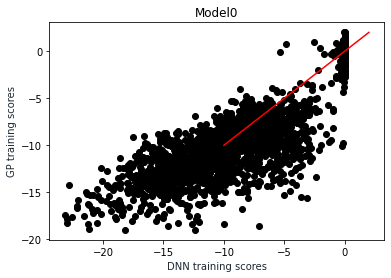

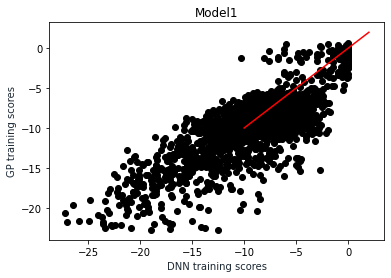

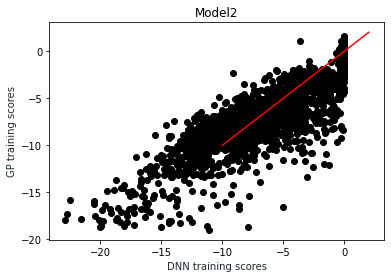

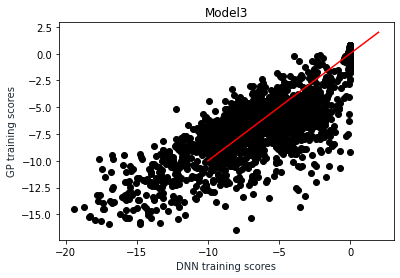

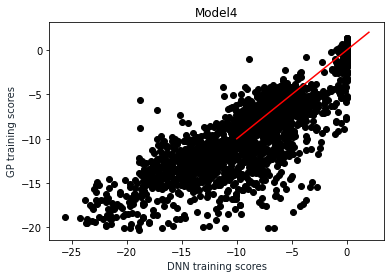

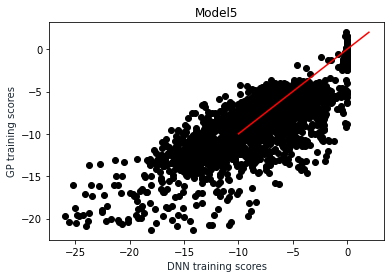

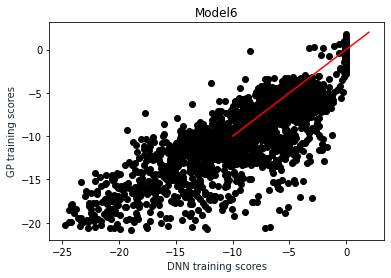

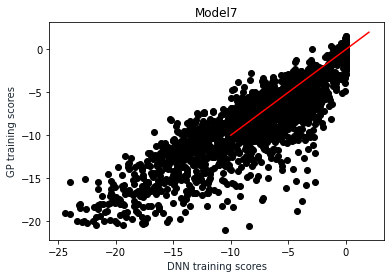

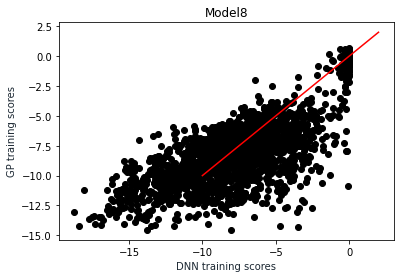

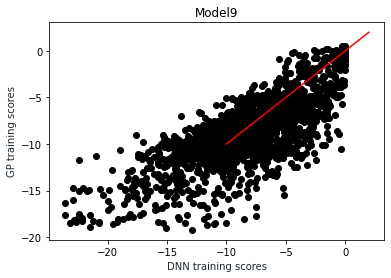

/tmp/ipykernel_250/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


derivative loss: tensor(0.0171)
Train Epoch: 1 [0/6400 (0%)]	Loss: 17.235966
derivative loss: tensor(0.0173)
Train Epoch: 1 [320/6400 (5%)]	Loss: 2.356950
derivative loss: tensor(0.0173)
Train Epoch: 1 [640/6400 (10%)]	Loss: 2.329077
derivative loss: tensor(0.0173)
Train Epoch: 1 [960/6400 (15%)]	Loss: 2.330535
derivative loss: tensor(0.0173)
Train Epoch: 1 [1280/6400 (20%)]	Loss: 2.128109
derivative loss: tensor(0.0173)
Train Epoch: 1 [1600/6400 (25%)]	Loss: 2.194625
derivative loss: tensor(0.0173)
Train Epoch: 1 [1920/6400 (30%)]	Loss: 2.226676
derivative loss: tensor(0.0174)
Train Epoch: 1 [2240/6400 (35%)]	Loss: 2.095765
derivative loss: tensor(0.0174)
Train Epoch: 1 [2560/6400 (40%)]	Loss: 2.002025
derivative loss: tensor(0.0174)
Train Epoch: 1 [2880/6400 (45%)]	Loss: 1.932642
derivative loss: tensor(0.0174)
Train Epoch: 1 [3200/6400 (50%)]	Loss: 1.833361
derivative loss: tensor(0.0174)
Train Epoch: 1 [3520/6400 (55%)]	Loss: 1.915299
derivative loss: tensor(0.0175)
Train Epoch: 1 

/home/cyy/.local/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6857, Accuracy: 523/640 (82%)

derivative loss: tensor(0.0178)
Train Epoch: 2 [0/6400 (0%)]	Loss: 1.702363
derivative loss: tensor(0.0178)
Train Epoch: 2 [320/6400 (5%)]	Loss: 1.210174
derivative loss: tensor(0.0179)
Train Epoch: 2 [640/6400 (10%)]	Loss: 1.331130
derivative loss: tensor(0.0179)
Train Epoch: 2 [960/6400 (15%)]	Loss: 1.141126
derivative loss: tensor(0.0179)
Train Epoch: 2 [1280/6400 (20%)]	Loss: 1.327558
derivative loss: tensor(0.0180)
Train Epoch: 2 [1600/6400 (25%)]	Loss: 1.024677
derivative loss: tensor(0.0180)
Train Epoch: 2 [1920/6400 (30%)]	Loss: 1.207984
derivative loss: tensor(0.0181)
Train Epoch: 2 [2240/6400 (35%)]	Loss: 0.955957
derivative loss: tensor(0.0181)
Train Epoch: 2 [2560/6400 (40%)]	Loss: 1.035682
derivative loss: tensor(0.0181)
Train Epoch: 2 [2880/6400 (45%)]	Loss: 1.012646
derivative loss: tensor(0.0182)
Train Epoch: 2 [3200/6400 (50%)]	Loss: 1.039899
derivative loss: tensor(0.0183)
Train Epoch: 2 [3520/6400 (55%)]	Loss: 0.

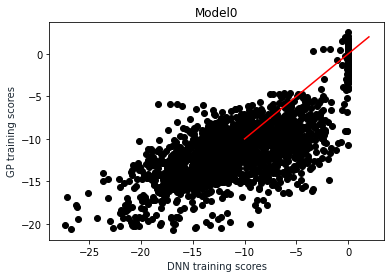

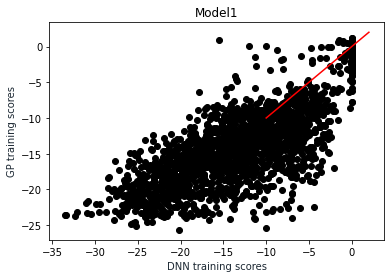

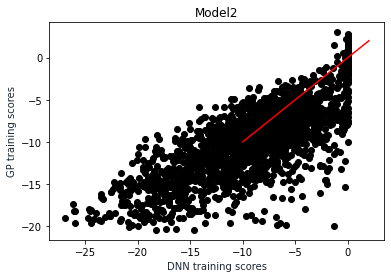

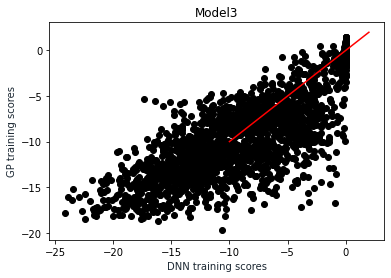

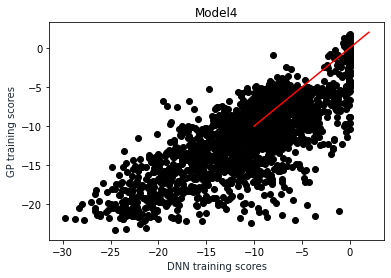

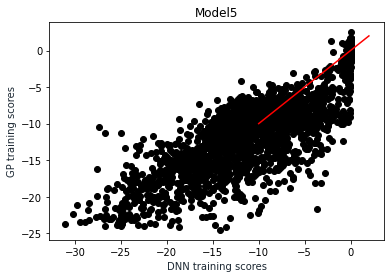

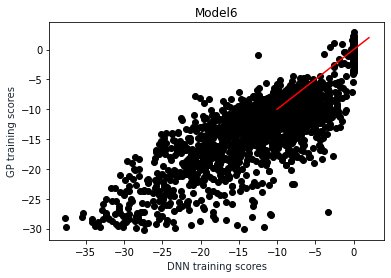

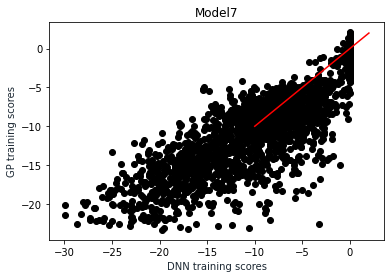

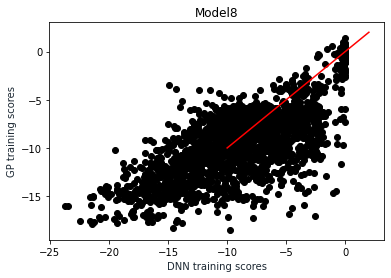

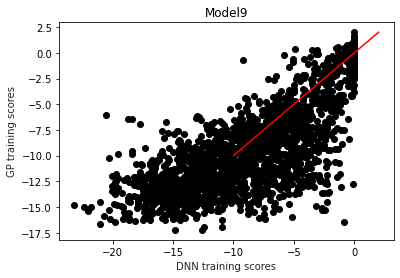

/tmp/ipykernel_250/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


derivative loss: tensor(0.0706)
Train Epoch: 1 [0/6400 (0%)]	Loss: 14.063284
derivative loss: tensor(0.0709)
Train Epoch: 1 [320/6400 (5%)]	Loss: 2.328950
derivative loss: tensor(0.0710)
Train Epoch: 1 [640/6400 (10%)]	Loss: 2.313093
derivative loss: tensor(0.0711)
Train Epoch: 1 [960/6400 (15%)]	Loss: 2.080586
derivative loss: tensor(0.0712)
Train Epoch: 1 [1280/6400 (20%)]	Loss: 1.936149
derivative loss: tensor(0.0713)
Train Epoch: 1 [1600/6400 (25%)]	Loss: 1.759130
derivative loss: tensor(0.0714)
Train Epoch: 1 [1920/6400 (30%)]	Loss: 1.777561
derivative loss: tensor(0.0715)
Train Epoch: 1 [2240/6400 (35%)]	Loss: 1.510368
derivative loss: tensor(0.0715)
Train Epoch: 1 [2560/6400 (40%)]	Loss: 1.513964
derivative loss: tensor(0.0716)
Train Epoch: 1 [2880/6400 (45%)]	Loss: 1.815495
derivative loss: tensor(0.0717)
Train Epoch: 1 [3200/6400 (50%)]	Loss: 1.609931
derivative loss: tensor(0.0718)
Train Epoch: 1 [3520/6400 (55%)]	Loss: 1.511772
derivative loss: tensor(0.0719)
Train Epoch: 1 

/home/cyy/.local/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6424, Accuracy: 516/640 (81%)

derivative loss: tensor(0.0726)
Train Epoch: 2 [0/6400 (0%)]	Loss: 1.372414
derivative loss: tensor(0.0727)
Train Epoch: 2 [320/6400 (5%)]	Loss: 0.924194
derivative loss: tensor(0.0729)
Train Epoch: 2 [640/6400 (10%)]	Loss: 1.206209
derivative loss: tensor(0.0730)
Train Epoch: 2 [960/6400 (15%)]	Loss: 1.303167
derivative loss: tensor(0.0731)
Train Epoch: 2 [1280/6400 (20%)]	Loss: 1.093787
derivative loss: tensor(0.0732)
Train Epoch: 2 [1600/6400 (25%)]	Loss: 0.986177
derivative loss: tensor(0.0733)
Train Epoch: 2 [1920/6400 (30%)]	Loss: 1.024773
derivative loss: tensor(0.0734)
Train Epoch: 2 [2240/6400 (35%)]	Loss: 0.970400
derivative loss: tensor(0.0734)
Train Epoch: 2 [2560/6400 (40%)]	Loss: 0.852417
derivative loss: tensor(0.0735)
Train Epoch: 2 [2880/6400 (45%)]	Loss: 1.055526
derivative loss: tensor(0.0737)
Train Epoch: 2 [3200/6400 (50%)]	Loss: 1.191602
derivative loss: tensor(0.0738)
Train Epoch: 2 [3520/6400 (55%)]	Loss: 0.

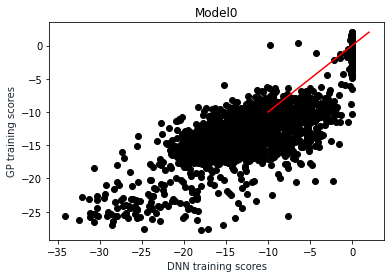

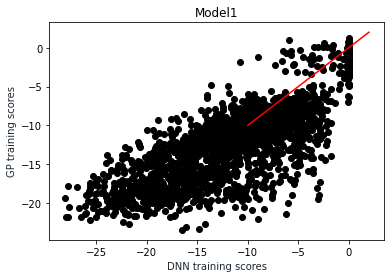

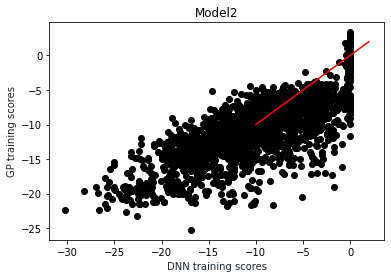

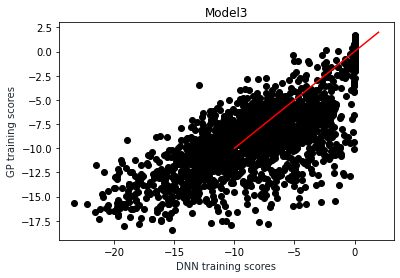

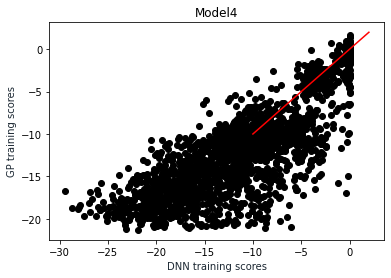

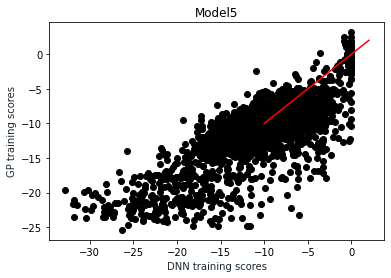

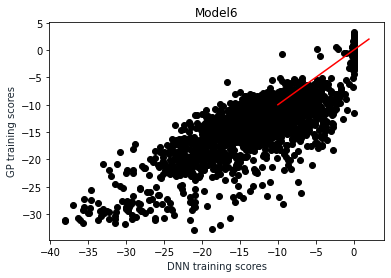

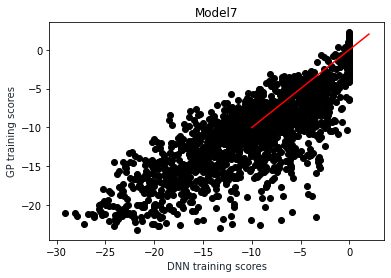

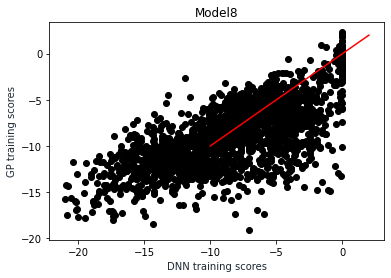

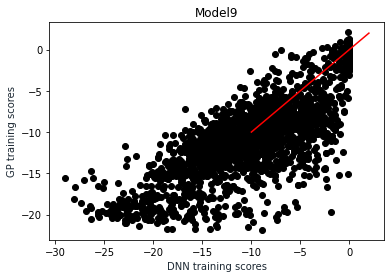

/tmp/ipykernel_250/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


derivative loss: tensor(0.1387)
Train Epoch: 1 [0/6400 (0%)]	Loss: 37.100655
derivative loss: tensor(0.1396)
Train Epoch: 1 [320/6400 (5%)]	Loss: 2.443255
derivative loss: tensor(0.1398)
Train Epoch: 1 [640/6400 (10%)]	Loss: 2.474454
derivative loss: tensor(0.1399)
Train Epoch: 1 [960/6400 (15%)]	Loss: 2.418693
derivative loss: tensor(0.1401)
Train Epoch: 1 [1280/6400 (20%)]	Loss: 2.442062
derivative loss: tensor(0.1402)
Train Epoch: 1 [1600/6400 (25%)]	Loss: 2.411803
derivative loss: tensor(0.1405)
Train Epoch: 1 [1920/6400 (30%)]	Loss: 2.426354
derivative loss: tensor(0.1407)
Train Epoch: 1 [2240/6400 (35%)]	Loss: 2.346625
derivative loss: tensor(0.1409)
Train Epoch: 1 [2560/6400 (40%)]	Loss: 2.166806
derivative loss: tensor(0.1411)
Train Epoch: 1 [2880/6400 (45%)]	Loss: 2.136035
derivative loss: tensor(0.1413)
Train Epoch: 1 [3200/6400 (50%)]	Loss: 2.208420
derivative loss: tensor(0.1416)
Train Epoch: 1 [3520/6400 (55%)]	Loss: 2.266965
derivative loss: tensor(0.1417)
Train Epoch: 1 

/home/cyy/.local/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0918, Accuracy: 472/640 (74%)

derivative loss: tensor(0.1432)
Train Epoch: 2 [0/6400 (0%)]	Loss: 1.351789
derivative loss: tensor(0.1434)
Train Epoch: 2 [320/6400 (5%)]	Loss: 1.431973
derivative loss: tensor(0.1436)
Train Epoch: 2 [640/6400 (10%)]	Loss: 1.438643
derivative loss: tensor(0.1437)
Train Epoch: 2 [960/6400 (15%)]	Loss: 1.370440
derivative loss: tensor(0.1439)
Train Epoch: 2 [1280/6400 (20%)]	Loss: 1.762935
derivative loss: tensor(0.1441)
Train Epoch: 2 [1600/6400 (25%)]	Loss: 1.366220
derivative loss: tensor(0.1443)
Train Epoch: 2 [1920/6400 (30%)]	Loss: 1.261536
derivative loss: tensor(0.1445)
Train Epoch: 2 [2240/6400 (35%)]	Loss: 1.400110
derivative loss: tensor(0.1447)
Train Epoch: 2 [2560/6400 (40%)]	Loss: 1.210767
derivative loss: tensor(0.1448)
Train Epoch: 2 [2880/6400 (45%)]	Loss: 1.165477
derivative loss: tensor(0.1450)
Train Epoch: 2 [3200/6400 (50%)]	Loss: 1.255446
derivative loss: tensor(0.1452)
Train Epoch: 2 [3520/6400 (55%)]	Loss: 1.

In [44]:
test()
# parameters = [10]
parameters = [0.1, 1, 5, 10, 30, 50, 100]
for para in parameter
:
    
    
    network = Net()
    optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
    for epoch in range(1, n_epochs + 1):
        train(epoch, para)
        test()
        
    trloader = torch.utils.data.DataLoader(trainset, batch_size=6400, shuffle=False)
    tsloader = torch.utils.data.DataLoader(valset, batch_size=640, shuffle=False)
    train_score = scores(trloader)
    # test_score = scores(tsloader)
    filename = "data/para" + str(para) + '_train_score.pt'
    torch.save(train_score, filename)
    # torch.save(test_score, 'test_score.pt')
    
    train_y = torch.load(filename)
    
    train_x, train_y = train_x[0: n], train_y[0: n, :]
    test_y = test_y.to(torch.int64)
    add = - torch.min(train_y) + 1
    log_y = add + train_y
    log_y = torch.log(log_y)
    
    
    models, likelihoods, mlls, opts = [], [], [], []
    model_initialize_GP()
    pred_train_y = []
    train_GP()
    
    
    for j in range(10):
        pred_train_y[j] = pred_train_y[j].view(1, -1).flatten()
        pred_train_y[j] = torch.exp(pred_train_y[j]) - add
        
    for j in range(10):
        name = "plots/para" + str(para) + "scaled_model" + str(j) +".png"
        x_data = train_y[:, j]
        mini = torch.min(x_data)
        if mini < -20:
            mini = -40
        else: 
            mini = -20
        y_data= pred_train_y[j]
        plt.plot(x_data, y_data, 'o', color='black')
        x = np.linspace(-10,2,100)
        y = x
        plt.plot(x, y, '-r', label='y=2x+1')
        plt.title('Model' + str(j))
        plt.xlabel('DNN training scores', color='#1C2833')
        plt.ylabel('GP training scores', color='#1C2833')
        plt.savefig(name, facecolor = 'white', transparent = False)
        plt.show()

In [ ]:
# plt.scatter(y_tr[0:500], train_score[0:500, 0])
# plt.show()
# torch.scatter(train_score[0:200, 0], index = torch.from_numpy(y_tr[0:200]))